In [1]:
import numpy as np
import pandas as pd

import emcee
import corner


# Locate results
import os
CWD = "/".join(os.getcwd().split("/")[:-2])


# astronomical units and constants
import astropy.units as u
from astropy.constants import R_sun

# Plot stuff
from funcs.model import full_model, aflare

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib 
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 

font = {'family' : 'courier',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

/work1/eilin/Flares_in_Clusters_2/RESULTS_Github/flares-in-clusters-with-k2-ii/flaresinclustersii/lib/python3.7/site-packages/html5lib/_trie/_base.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping
/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [43]:
# What dataset do you want to analyse?
ID = 277539431#44984200#230120143#237880881##212035340 #230120143#
tstamp = "08_07_2020_11_48"#"20_02_2020_12_04"#'13_12_2019_10_18'#'27_01_2020_12_28'#

In [44]:
# Pick up the input parameters
inits = pd.read_csv(f"{CWD}/data/summary/inits.csv")
inits = inits[(inits.ID == str(ID)) & (inits.tstamp==tstamp)].iloc[0]

qlum = inits.qlum_erg_s * u.erg / u.s
Fth = inits.Fth * u.erg/ u.cm**2 / u.s
median = inits['median']
R = inits.R_Rsun * R_sun

In [45]:
props = pd.read_csv(f"{CWD}/data/summary/everything.csv")
target = props[props.ID == ID].iloc[0]


In [46]:
median

778.0555449030055

In [47]:
lc = pd.read_csv(f"{CWD}/data/lcs/{tstamp}_{ID}.csv")

In [48]:
lc

,phi,flux,t,flux_err,median_
0,0.022964,785.423931,1641.601225,6.840248,778.055545
1,0.091858,788.291581,1641.603308,6.840248,778.055545
2,0.137787,773.793075,1641.604697,6.840248,778.055545
3,0.206680,784.566846,1641.606780,6.840248,778.055545
4,0.275573,788.664446,1641.608864,6.840248,778.055545
...,...,...,...,...,...
886,54.242043,769.821431,1643.240779,6.840248,778.055545
887,54.310937,778.817563,1643.242863,6.840248,778.055545
888,54.379830,781.151914,1643.244946,6.840248,778.055545
889,54.425759,783.226951,1643.246335,6.840248,778.055545


In [49]:
# see here https://emcee.readthedocs.io/en/stable/tutorials/monitor/
filename = f"{CWD}/analysis/results/mcmc/{tstamp}_{target.ID}_MCMC.h5"
reader = emcee.backends.HDFBackend(filename)

tau = reader.get_autocorr_time()
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
# burnin=4000
# thin=50
ndim=6
samples = reader.get_chain(discard=burnin, flat=True, thin=thin)
log_prob_samples = reader.get_log_prob(discard=burnin, flat=True, thin=thin)
log_prior_samples = reader.get_blobs(discard=burnin, flat=True, thin=thin)

print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(samples.shape))
print("flat log prob shape: {0}".format(log_prob_samples.shape))


burn-in: 1861
thin: 103
flat chain shape: (314432, 6)
flat log prob shape: (314432,)


In [51]:
columns = ["phase_peak","latitude_rad","a","fwhm_periods","i_rad","phase_0"]
rawsamples = pd.DataFrame(data=samples, columns=columns)
rawsamples.to_csv(f"{CWD}/analysis/results/mcmc/{target.ID}_{tstamp}_raw_mcmc_sample.csv",index=False)

In [52]:
target.ID

277539431

burn-in: 13333
thin: 186
flat chain shape: (113152, 6)
flat log prob shape: (113152,)



TIC 277
thin: 103
flat chain shape: (314432, 6)
flat log prob shape: (314432,)



TIC 449
burn-in: 158
thin: 36
flat chain shape: (908416, 6)
flat log prob shape: (908416,)


In [53]:
# map phi0 to phi_peak longitude, still call it phi0
samples[:, -1] = (samples[:, 0]%(2.*np.pi) - samples[:, -1]) / np.pi * 180. # 0 would be facing the observer

#map phi_a_distr to t0_distr:
samples[:, 0] = np.interp(samples[:,0],lc.phi,lc.t)

# convert theta_f to degrees
samples[:, 1] = samples[:, 1] / np.pi * 180.

# convert FWHM to days
samples[:, 3] = samples[:, 3]/2/np.pi*target.Prot_d 

# convert i to degrees
samples[:, -2] = samples[:, -2] / np.pi * 180.



# Plots
### Plot the full chain

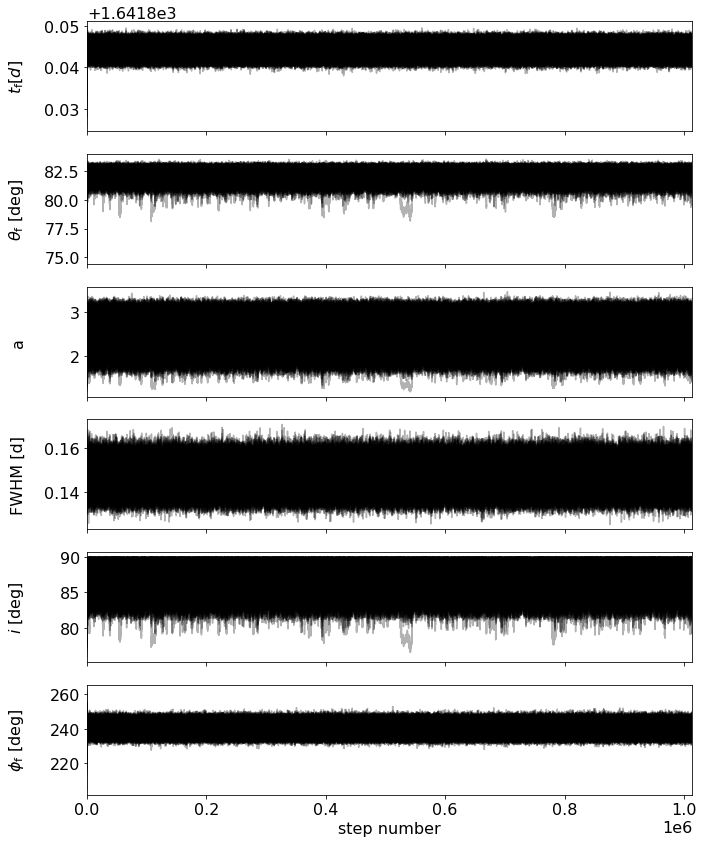

In [54]:
fig, axes = plt.subplots(6, figsize=(10, 12), sharex=True)

multi_samples = reader.get_chain()
walkers = multi_samples.shape[1]
steps = multi_samples.shape[0]
nparam = multi_samples.shape[2]
# -----------------------------------------------------------------------
# map phi0 to phi_peak longitude, still call it phi0
multi_samples[:, :,-1] = (multi_samples[:,:,0]%(2.*np.pi) - multi_samples[:,:, -1]) / np.pi * 180.  # 0 would be facing the observer

#map phi_a_distr to t0_distr:
multi_samples[:, :, 0] = np.interp(multi_samples[:,:,0],lc.phi,lc.t)

# convert theta to degrees
multi_samples[:, :, 1] = multi_samples[:,:, 1] / np.pi * 180.

# convert FWHM to days
multi_samples[:, :, 3] = multi_samples[:,:,3]/2/np.pi*target.Prot_d 

# convert i to degrees
multi_samples[:, :, -2] = multi_samples[:,:, -2] / np.pi * 180.
# -----------------------------------------------------------------------
labels = [r'$t_\mathrm{f} [d]$', r'$\theta_\mathrm{f}$ [deg]', 
          'a', 'FWHM [d]', r'$i$ [deg]',
          r"$\phi_\mathrm{f}$ [deg]"]
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 
for j in range(ndim):
    ax = axes[j]
    ax.plot(multi_samples[:, :, j], "k", alpha=0.3)
    ax.set_xlim(0, len(multi_samples))
    ax.set_ylabel(labels[j])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
plt.tight_layout()
plt.savefig(f"{CWD}/analysis/plots/flarefit/{tstamp}_{target.prefix}{target.ID}_chain.png",dpi=300)

### Corner plot

In [ ]:

print(samples.shape)
fig = corner.corner(samples, labels=labels)# truths=[phi_a, theta_a, a, fwhm,i_mu, phi0]);
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 
plt.savefig(f"{CWD}/analysis/plots/flarefit/{tstamp}_{target.prefix}{target.ID}_corner_disc{burnin}.png",dpi=300)

(314432, 6)


### Retrieve and plot some example fits to the data from the chain

In [ ]:
median

In [ ]:
samples2 = reader.get_chain(discard=burnin, flat=True, thin=thin)
N = 50
time = lc.t
phi = lc.phi.values
flux = lc.flux.values
#inds = np.rint(np.linspace(len(samples2)-6, 40)).astype(int) - KIC100

inds = np.random.randint(len(samples2), size=N)
plt.figure(figsize=(10,8))
#plt.scatter(flck.time, flck.flux, s=1)
plt.scatter(time, flux, s=10, c="k",label=r"de-trended light curve")
#plt.errorbar(phi, flux, yerr=flux_err, fmt=".k", capsize=0)

for ind in inds:
    sample = samples2[ind]
    phi_a, theta_a, a, fwhm, i, phi0 = sample

    plt.plot(time, aflare(phi, phi_a, fwhm, a*median)+ median, c="grey", alpha=0.05, linewidth=3)
    plt.plot(time, full_model(phi_a, theta_a, a, fwhm, i, phi0=phi0,
               phi=phi, num_pts=50, qlum=qlum,
               Fth=Fth, R=R, median=median), c="r", alpha=0.25)
    
plt.plot(time, aflare(phi, phi_a, fwhm, a*median)+ median, c="grey", alpha=1, linewidth=3,label="flare model")
plt.plot(time, full_model(phi_a, theta_a, a, fwhm, i, phi0=phi0,
               phi=phi, num_pts=50, qlum=qlum,
               Fth=Fth, R=R, median=median), c="r", alpha=.25,label="modulated flare")
#plt.plot(phi, flare+median, c="r",linewidth=1)
plt.legend(fontsize=16)
plt.xlabel(f"time [BJD - {target.BJDoff}]",fontsize=16)
plt.ylabel(r"flux ($e^{-}$ / s)",fontsize=16);
plt.yscale("log")
plt.tight_layout()
#plt.ylim(1650,2200)
plt.ylim(700,3300)
#plt.ylim(2300,2500)
plt.xlim(lc.t.min(), lc.t.max())
plt.savefig(f"{CWD}/analysis/plots/flarefit/{tstamp}_{target.prefix}{target.ID}_flarefit_{N}retrievals.png",dpi=300)

In [ ]:
median

# Results

In [ ]:
from funcs.model import calculate_angular_radius, calculate_ED

In [ ]:
percentiles = [16,50,84]

In [ ]:
columns = ["t0_d","latitude_deg","a","fwhm_d","i_deg","phase_deg"]
resultframe = pd.DataFrame(data=samples, columns=columns)


resultframe.to_csv(f"{CWD}/analysis/results/mcmc/{target.ID}_{tstamp}_converted_mcmc_sample.csv",index=False)

In [ ]:
resultframe["rad_rsun"] = resultframe.apply(lambda x: calculate_angular_radius(Fth, x.a, qlum, R), axis=1)

In [ ]:
resultframe["ED_s"] = resultframe.apply(lambda x: calculate_ED(lc.t.values, 
                                                                   x.t0_d, 
                                                                   x.fwhm_d, 
                                                                   x.a),
                                           axis=1)

In [ ]:
plt.hist(resultframe.rad_rsun.values,bins=100, histtype="step",color="k",linewidth=2);
plt.xlabel("angular radius [deg]")
radius_p = np.percentile(resultframe.rad_rsun.values, percentiles, axis=0)
plt.savefig(f"{CWD}/analysis/plots/flarefit/{tstamp}_{target.prefix}{target.ID}_active_region_radii.png",dpi=300)

In [ ]:
ED_distr = resultframe.ED_s.values
ED_distr_p = np.percentile(ED_distr, percentiles, axis=0)
plt.hist(ED_distr,bins=200, histtype="step",color="k",linewidth=2);
plt.xlabel("ED [s]")
plt.savefig(f"{CWD}/analysis/plots/flarefit/{tstamp}_{target.prefix}{target.ID}_flare_ED.png",dpi=300)

In [ ]:

t0_p, theta_a_p, a_p, fwhm_p, i_p, phi0_p = map(lambda v: (v[0], v[1], v[2]),
                                                   zip(*np.percentile(samples, percentiles,
                                                       axis=0)))


with open(f"{CWD}/analysis/results/mcmc/mcmcoutput.csv","a") as f:
    #Add more lines here
    
    out = f"{tstamp},{target.ID},{burnin},{steps},{walkers},{nparam},"
    firstout = f"date,ID,burnin,steps,walkers,nparam,"
    for i in ['t0_p', 'theta_a_p', 'a_p', 'fwhm_p', 'i_p', 'phi0_p', 'radius_p', 'ED_distr_p', 'Eflare_p']:
        firstout += f"{i}{percentiles[0]},{i}{percentiles[1]},{i}{percentiles[2]},"
    for i in [t0_p, theta_a_p, a_p, fwhm_p, i_p, phi0_p, radius_p, ED_distr_p, (ED_distr_p*qlum).value ]:
        out += f"{i[0]},{i[1]},{i[2]},"
    out += "\n"
    firstout += "\n"
    f.write(firstout)
    f.write(out)